# Chinese MNIST
The goal is to build a model able to correctly classify an image representing a **Chinese number** (a Hanzi character).  
This is a multi-class classification problem. There are a total of 15 possible classes: the characters representing numbers from 0 to 10, plus the ones for 100, 1000, 10000, 100000000.  
The intention is to implement the model via a deep neural network (a convolutional network) using the pyTorch framework.  
## Read and explore the data

The dataset contains the following:

- an index file: chinese_mnist.csv
- a folder with 15,000 jpg images, sized 64 x 64. The images are handwritten chinese numbers.   
  
Here is the mapping for the index file:
- suite ID: number from 1 to 99; 100 volunteers hand wrote a suite of numbers
- sample ID: number from 1 to 10;
- character: the actual Chinese number (Unicode notation)
- value: the number in arab notation
- code: an ID from 1 to 15
  
Let's have a closer look at the index file:


In [1]:
import pandas as pd

In [2]:
dataDF = pd.read_csv("../datasets/chinese-mnist/chinese_mnist.csv")
dataDF.head(5)

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [3]:
dataDF.tail(5)

,suite_id,sample_id,code,value,character
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八
14999,99,9,9,8,八


In [4]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


In [5]:
dataDF.isnull().sum(), dataDF.shape

(suite_id     0
 sample_id    0
 code         0
 value        0
 character    0
 dtype: int64,
 (15000, 5))

There is no missing values and number of data and number of images match: a total of 15K.

In [6]:
characters = dataDF['character'].unique().tolist()
print(characters)
print(len(characters))

['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15


As you can see, there are a total of 15 different Chinese characters. This is because, not only the usual numbers from 0 to 9 are represented, but also for one hundred, one thousand and so on (they have their own Hanzi character):

In [7]:
values = dataDF['value'].unique().tolist()
print(values)
print(len(values))

[9, 10, 100, 1000, 10000, 100000000, 0, 1, 2, 3, 4, 5, 6, 7, 8]
15


In [8]:
dataDF.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

As it would be more difficult to train a network using the face value number, a code has been also introduced to map each single character and it will be the one used for the target variable:

In [9]:
codes = dataDF['code'].unique().tolist()
print(codes)
print(len(codes))

[10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9]
15


In [10]:
dataDF.groupby(["code","character"]).size()

code  character
1     零            1000
2     一            1000
3     二            1000
4     三            1000
5     四            1000
6     五            1000
7     六            1000
8     七            1000
9     八            1000
10    九            1000
11    十            1000
12    百            1000
13    千            1000
14    万            1000
15    亿            1000
dtype: int64

Each character is present 1K times (15 characters = 15K entries) with own hand written image.  
The total number of classes to predict are 15.  

In [11]:
OUTPUT_SIZE = len(codes)
OUTPUT_SIZE

15

### Preprocess the data
The images are in separate files, we need to put all together in the dataset:

In [12]:
import os

In [13]:
IMAGE_PATH = "../datasets/chinese-mnist/data/data/"
print("dataframe (index file) rows:", dataDF.shape[0]) 
print("image files :", len(os.listdir(IMAGE_PATH)))

dataframe (index file) rows: 15000
image files : 15000


This is the file format:

In [14]:
filenames = os.listdir(IMAGE_PATH)
filenames[0:5]

['input_69_2_7.jpg',
 'input_11_7_12.jpg',
 'input_81_4_10.jpg',
 'input_84_6_1.jpg',
 'input_36_3_3.jpg']

It's "input_" + suite ID + sample ID +  code ID, so we can programmatically build the filename and add it to the data frame.  

In [71]:
dataDF['file'] = dataDF[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataDF.head(5)

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [91]:
dataDF.tail(3)

,suite_id,sample_id,code,value,character,file
14997,99,7,9,8,八,input_99_7_9.jpg
14998,99,8,9,8,八,input_99_8_9.jpg
14999,99,9,9,8,八,input_99_9_9.jpg


### Check the image from the file
Here we are using the Image class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image automatically.  
In a neural network, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor ("embedding").

In [72]:
from PIL import Image

In [73]:
indexImage = 4000 # feel free to use any index from 0 to 15k

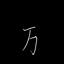

In [74]:
imgPath =  os.path.join(IMAGE_PATH, dataDF['file'][indexImage]) 
im = Image.open(imgPath)
im

In [75]:
im.size

(64, 64)

Images are 64x64 pixels.  
Let's add this as constant.

In [76]:
IMG_SIZE = im.size[0]

In [77]:
imgPath

'../datasets/chinese-mnist/data/data/input_1_1_14.jpg'

In [78]:
dataDF['character'][indexImage]

'万'

Yep, this looks the same character as above.

In [79]:
print("Label: this is a ", dataDF['value'][indexImage])

Label: this is a  10000


In [80]:
dataDF['code'][indexImage]

14

And the code (=the class) for the 10000 character is 14.

## Prepare a dataset
For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset.

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
  
The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms.
  
The __len__ function returns the number of samples in our dataset.
  
The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, for this dataset, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable) and returns the tensor image and corresponding label in a tuple.

In [81]:
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split

In [82]:
class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir):
        self.df = annotations_dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath =  os.path.join(self.img_dir, self.df ['file'][idx]) 
        img = Image.open(imgPath)

        imgAsT = torch.from_numpy(np.array(img)).float()

        label = self.df['code'][idx] -1 # let's use the code as target variable
        
        return imgAsT, label


Get the data frame (we can use any Python collection) into the custom dataset and then we try to retrieve an image given an index:

In [83]:
chineseNumbers = ChineseMNISTdataset(dataDF, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length

15000

In [84]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)

torch.Size([64, 64])
9


Note that it returns a tensor of size 64x64 and a label.  
in this case, should be the character representing the value 9.  
We can verify it by plotting the tensor (it's basically a pixel representation of the grey scale of the character):

In [85]:
import matplotlib.pyplot as plt

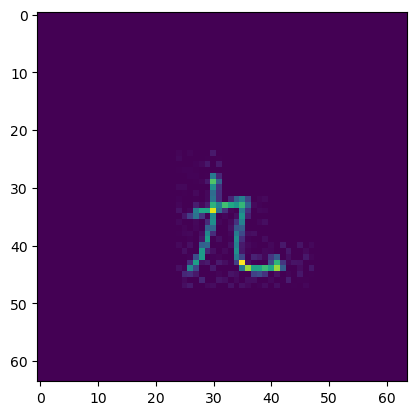

In [86]:
plt.imshow(img)

Yes, that's the number 9. So far so good. Now need to carve out a subset for testing evaluation.  
## Split into training and testing datasets
We split the dataset into a training and a testing dataset: 90% and 10%

In [87]:
SEED = 42 # "Answer to the Ultimate Question of Life, the Universe, and Everything"

torch.manual_seed(SEED)  # for reproducibility 
np.random.seed(SEED)

In [88]:
testSize = chineseNumbers.__len__() // 10 # integer divide , reserve 10% for testing
trainSize = chineseNumbers.__len__() - testSize

In [89]:
# splitting the data
# Train-test split
trainDataset, testDataset = random_split(chineseNumbers, [trainSize, testSize])

len(trainDataset), len(testDataset)

(13500, 1500)

In [90]:
type(testDataset)

torch.utils.data.dataset.Subset

The testing Subset contains in total 1500 images (that's 10% of the original dataset, as expected).  
## Build a data loader from the datasets
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting and use Python’s multiprocessing to speed up data retrieval.
  
We get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch provides a class that will do the shuffling and mini-batch collation, called DataLoader.
  
DataLoader is an iterable that abstracts this complexity for us in an easy API.  
A DataLoader can take any Python collection and turn it into an iterator over mini-batches, like so:

In [92]:
coll = range(14)  # example of dataloader
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 4,  2,  1, 10, 13]),
 tensor([ 3,  9,  5,  6, 12]),
 tensor([ 8,  7,  0, 11])]

Every mini batch is size five and since the total entries in the dataloader is 14, the last mini batch is smaller.  
For the Chinese numbers dataset we can define a larger batch, let's say one hundred:  

In [93]:
BATCH_SIZE = 100 

In [94]:
trainLoader = DataLoader(trainDataset, BATCH_SIZE, shuffle=True)
testLoader = DataLoader(testDataset, BATCH_SIZE, shuffle=True)

In [95]:
type(trainLoader)

torch.utils.data.dataloader.DataLoader

## Define the CNN  
We define the neural network by subclassing the PyTorch nn.Module class.  
There is an __init__() method that defines the layers and other components of a model, and a forward() method where the computation gets done.  
We initialise the neural network layers in __init__ and every nn.Module subclass implements the operations on input data in the forward method.   
nn.Sequential is an ordered container of modules and is used as quick way to structure the network. The data is passed through all the modules in the same order as defined.  

I use the same layers which I previously used to classify numbers in the arab notation (classic MNIST dataset).  
  
Convolutional layers are built to handle data with a high degree of spatial correlation. They are very commonly used in computer vision, where they detect close groupings of features which the compose into higher-level features.  
  
A convolutional layer is like a window that scans over the image, looking for a pattern it recognizes. These patterns are called features and one of the parameters of a convolutional layer is the number of features we would like it to learn. This is the second argument to the constructor: the number of output features. Here, we’re asking our layer to learn 8 features.

The last linear layer of the neural network returns logits - raw values - which are passed to the nn.Softmax module. The logits are scaled to values [0, 1] representing the model’s predicted probabilities for each class. dim parameter indicates the dimension along which the values must sum to 1.

In [96]:
import torch.nn as nn

In [97]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer = nn.Flatten() # actually not used
        self.layers = nn.Sequential(
            nn.Conv2d(1,8, kernel_size=3, padding='same'),  # input layer: 1 input image channel (black & white), 8 output channels, 3x3 square convolution
            nn.ReLU(),  # pass through a ReLu activation function
            nn.Flatten(), 
            nn.Linear(in_features=8*IMG_SIZE*IMG_SIZE, out_features=25), # hidden layer
            nn.ReLU(),  # pass through a ReLu activation function
            nn.Linear(25, OUTPUT_SIZE)  # output layer
        )
        self.outputLayer = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1) # to single channel image
        logits = self.layers(x)  # the actual step going through the above defined layers
        out = self.outputLayer(logits) # call the softmax function
        return out

### Get Device for Training
Before we implement the neural network, we want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. Let’s check to see if torch.cuda or torch.backends.mps are available, otherwise we use the CPU.

In [98]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


We create an instance of the CNN,  move it to the device and print its structure.

In [99]:
simpleModel = ConvolutionalNeuralNetwork().to(device)
print("The model: ", simpleModel)

The model:  ConvolutionalNeuralNetwork(
  (inputLayer): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=32768, out_features=25, bias=True)
    (4): ReLU()
    (5): Linear(in_features=25, out_features=15, bias=True)
  )
  (outputLayer): Softmax(dim=1)
)


The layers (a total of six layers) and related weights are stored in the internal variable 'parameters':

In [100]:
params = list(simpleModel.parameters())
len(params)

6

In [101]:
num_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
print("Total number of trainable model parameters:", num_params)

Total number of trainable model parameters: 819695


You can check single layers including its weights and shape:

In [45]:
named_params = [p for p in simpleModel.named_parameters()]
print(named_params[-1])

('layers.5.bias', Parameter containing:
tensor([ 0.0354,  0.0361,  0.1400, -0.1707, -0.0041, -0.1914,  0.1261, -0.1008,
         0.0768,  0.0004,  0.0448, -0.1565, -0.1023, -0.1986, -0.1746],
       device='mps:0', requires_grad=True))


In [46]:
print(simpleModel.layers[0].weight.shape)


torch.Size([8, 1, 3, 3])


## Train the model
Before starting the training, we need to define a loss and an optimiser function.

The loss function measures the degree of dissimilarity of obtained result to the target value and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks and nn.NLLLoss (Negative Log Likelihood) for classification.  
nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

In [47]:
lossFn = nn.CrossEntropyLoss()

Optimisation is the process of adjusting model parameters to reduce model error in each training step. Optimisation algorithms define how this process is performed. All optimisation logic is encapsulated in the optimiser object. Here, we use the Stochastic Gradient Descent, SGD optimiser; there are many different optimisers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

In [48]:
LEARNING_RATE = 0.01

In [65]:
#optimiser = torch.optim.SGD(simpleModel.parameters(), lr = LEARNING_RATE)
optimizer = torch.optim.Adam(simpleModel.parameters(), lr=LEARNING_RATE)  # got better results with SGD


Each iteration below returns a batch of train_features and train_labels (containing batch_size features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled  

In [66]:
NUM_EPOCHS = 10 # we start low

In [69]:
lossHistory = []

simpleModel.train()  # just say the model is used for training phase

for e in range(NUM_EPOCHS):

    print(f"Epoch: {e+1}/{NUM_EPOCHS}")

    epochLoss = 0
    correct = 0
    totalExamples = 0
    trainLosses = []


    for batchIdx, (X, y) in enumerate(trainLoader):

        # X is the images in all the batch so the shape is BATCH_SIZE (or less for the last batch) * image shape
        # y is the labels in all the batch so the shape is <= BATCH_SIZE
        
            # Make sure to pass batch-data to the correct device, otherwise get runtime error

        X = X.to(device)
        y = y.to(device)


        logits = simpleModel(X)  # 1. forward pass; generate the predictions

        batchLoss = lossFn(logits, y)  # 2. calculate the loss
        trainLosses.append(batchLoss.detach()) # add to loss history (detach is removing the grad information); just to see the trend

        batchLoss.backward()  # 3. backward pass

        optimiser.step()  # 4. update model
        optimiser.zero_grad() # reset the gradient

        epochLoss += batchLoss.item() # add to total epoch loss
        
            # print the status every 50 batches
        if batchIdx % 50 == 0:
            totImages = batchIdx * BATCH_SIZE + len(X)
            print(f"\tIteration: {batchIdx}\t Current batch Loss: {batchLoss:.3f} | images: {totImages} | epoch loss/n: {epochLoss/len(trainLoader): .3f}")

            # update the accuracy
        preds = torch.argmax(logits, dim = 1)
        compare = y == preds
        correct += torch.sum(compare)
        totalExamples += len(compare)

    print(f"  Train epoch loss: {epochLoss:.2f} | mean: {torch.stack(trainLosses).mean().item():.2f} | accuracy: {(correct / totalExamples).item():.2f}")
    lossHistory.append(torch.stack(trainLosses).mean().item())

print("Done!")


Epoch: 1/10
	Iteration: 0	 Current batch Loss: 2.061 | images: 100 | epoch loss/n:  0.015
	Iteration: 50	 Current batch Loss: 2.039 | images: 5100 | epoch loss/n:  0.788
	Iteration: 100	 Current batch Loss: 2.009 | images: 10100 | epoch loss/n:  1.561
  Train epoch loss: 281.72 | mean: 2.09 | accuracy: 0.73
Epoch: 2/10
	Iteration: 0	 Current batch Loss: 2.122 | images: 100 | epoch loss/n:  0.016
	Iteration: 50	 Current batch Loss: 2.065 | images: 5100 | epoch loss/n:  0.789
	Iteration: 100	 Current batch Loss: 2.180 | images: 10100 | epoch loss/n:  1.557
  Train epoch loss: 281.04 | mean: 2.08 | accuracy: 0.74
Epoch: 3/10
	Iteration: 0	 Current batch Loss: 2.081 | images: 100 | epoch loss/n:  0.015
	Iteration: 50	 Current batch Loss: 2.058 | images: 5100 | epoch loss/n:  0.788
	Iteration: 100	 Current batch Loss: 2.117 | images: 10100 | epoch loss/n:  1.555
  Train epoch loss: 280.50 | mean: 2.08 | accuracy: 0.74
Epoch: 4/10
	Iteration: 0	 Current batch Loss: 2.128 | images: 100 | epoc

The loss should decrease and the accuracy increase towards 1.0 (means 100% accuracy), epoch after epoch.  
The iterations metrics inside each epoch is just to check the general trend (losses may vary inside the epoch becuase the batches are random but from one eopch to the other should decrease).  
In this case 3 epochs are enough to achieve good numbers (at least for the training dataset).  
It's visible in the plot:

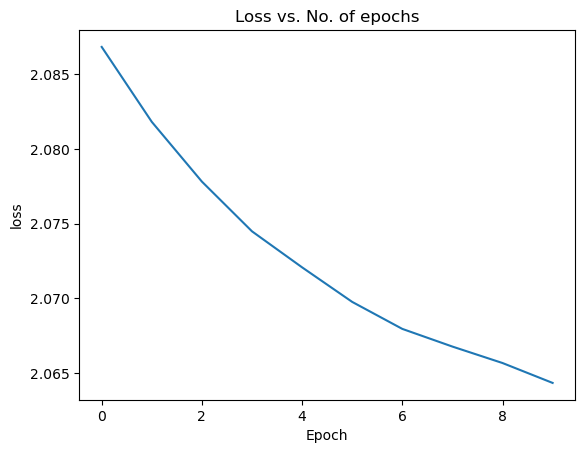

In [70]:
plt.plot(lossHistory)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.show()

## Predict one single image
Let's check how to predict the class (the code) for a single test image:

In [53]:
def predictImage (model, img, y):
    x = img.reshape(1,64,64) # prepare as input for the model (it's like a batch of one item)
    model.eval() # tell model we are in evaluation mode, not training

    with torch.no_grad():
        logits = model(x) # run the model to get the prediction
        pred_prob = nn.Softmax(dim=1)(logits)
        y_pred = pred_prob.argmax(1)
        
    print("Predicted class: ", int(y_pred))
    print(f"Compare with correct class = {y}: this is {y_pred == y}")

In [54]:
testImg, testLabel = testDataset[100]   # cannot use getItem on subset, we index directly
testLabel

9

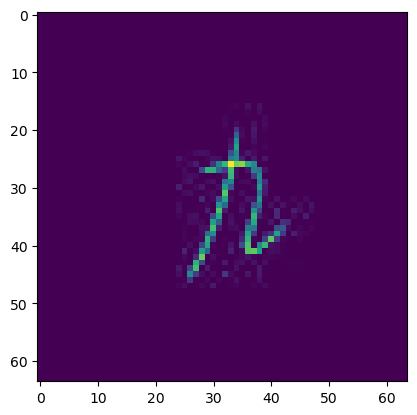

In [55]:
plt.imshow(np.array(testImg).astype(int))

In [56]:
predictImage (simpleModel, testImg.to(device), testLabel)

Predicted class:  9
Compare with correct class = 9: this is tensor([True], device='mps:0')


## Compute accuracy on testing dataset
Finally, to be sure it's not overfitted, let's check the accuracy on the testing dataset.  
It also computes the confusion matrix. Ideally all numbers are on the diagonal (each class is correctly predicted) and outside is all zero.

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
def computeAccuracy(model, data):
    model = model.eval()
    correct = 0.0
    totalExamples = 0
    totalLabels = np.array([])
    totalPred = np.array([])

    for idx, (features, labels) in enumerate(data):
        with torch.no_grad():
            features = features.to(device)
            labels = labels.to(device)
            logits = model(features) # run the model to get the predictions

        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions  # compare predictions with true label

        correct += torch.sum(compare)
        totalExamples += len(compare)

        totalLabels = np.concatenate((totalLabels, labels.cpu().numpy()))
        totalPred = np.concatenate((totalPred, predictions.cpu().numpy()))

    cm = confusion_matrix(totalLabels, totalPred)  # assemble the confusion matrix and print it
    print(f'Confusion matrix: \n{cm}')

    return (correct / totalExamples).item()  # return the accuracy


In [59]:
acc = computeAccuracy(simpleModel, testLoader)
print(f"\nAccuracy: {acc*100} %")

Confusion matrix: 
[[78  0  0  0  1  0  2  0  0  2  0  0  2  2  0]
 [ 1 96 17  0  1  0  1  0  0  0  0  0  0  1  0]
 [ 0 23 71  0  0  2  1  0  0  0  0  0  0  0  0]
 [ 4 14 39  0  0 12  5  0  0  0  1  0  0  0  0]
 [ 7  0  0  0 93  2  0  0  1  2  0  0  0  2  0]
 [ 4  5  0  0  1 85  1  0  2  4  4  0  1  2  0]
 [ 5  4  4  0  1  3 61  0  0  2  0  0  1 15  0]
 [ 3  3  2  0  8 20  4  0  2 39 12  0  9  1  0]
 [ 0  0  0  0  3  0  3  0 85 20  1  0  1  0  0]
 [ 3  0  0  0  8  6  1  0  4 81  1  0  0  2  0]
 [ 0  0  0  0  7  0  0  0  1  5 67  0 16  3  0]
 [16  0  6  0 10 23  0  0  0  3  4  0  3 31  0]
 [ 3  0  1  0  2  2 11  0  0  5 29  0 52  0  0]
 [ 5  0  1  0  4  3  0  0  2  8  2  0  2 65  0]
 [ 3  0  0  0 28  1  0  0  4 59  1  0  0  2  0]]

Accuracy: 55.59999942779541 %


As a comparison, a baseline would be if the class is randomly chosen , then would be 1 out of 15:

In [60]:
1/15

0.06666666666666667

As it's good enough, no need to add regularisation techniques such as the dropout.  
Finally, the model can be saved:

In [62]:
print("Saving the trained model")
torch.save(simpleModel.state_dict(), os.path.join(os.getcwd(), "Net.pth"))

Saving the trained model
